<a href="https://colab.research.google.com/github/RithuLoki/Early-Health-Risk-Screening---ML/blob/main/Early_Health_Risk_Screening_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early Health Risk Screening using Machine Learning (Non-Diagnostic)

- Preventive healthcare focuses on identifying early warning patterns before serious
health conditions develop. This project explores whether basic lifestyle indicators
such as sleep habits, stress levels, physical activity, and daily routines can be
used to screen potential health risk patterns at an early stage.

- The goal is not to diagnose any disease, but to provide a preventive risk
screening approach that can increase awareness and encourage healthier choices.


## Environment Setup and Library Imports

This section initializes the Python environment by importing the essential
libraries required for data manipulation, visualization, and analysis.
Pandas and NumPy are used for handling data, while Matplotlib and Seaborn
are used for visual exploration of the dataset.

Basic display and visualization settings are also configured to ensure
readable tables and consistent plot styling throughout the notebook.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# Disable widget state saving (GitHub compatibility)
import os
os.environ["COLAB_DISABLE_WIDGET_STATE"] = "1"

# SHAP execution control (disabled due to environment compatibility)
ENABLE_SHAP = False

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Essential libraries imported and notebook configured.")

Essential libraries imported and notebook configured.


## Synthetic Lifestyle Data Generation

Since real medical and personal data cannot be used due to privacy and ethical
concerns, a synthetic dataset is generated to simulate realistic lifestyle
patterns.

The dataset includes non-clinical features such as age, diet quality, physical
activity, sleep duration, stress levels, smoking and alcohol habits, and BMI.
These variables are commonly associated with general health risk trends and
are suitable for preventive screening analysis.

## Health Risk Score Construction

A composite health risk score is created using a weighted combination of
lifestyle factors. Higher risk behaviors contribute positively to the score,
while healthier habits reduce the overall risk.

This score is scaled between 0 and 100 and used to create a binary high-risk
flag, which serves as the target variable for further analysis and modeling.


In [2]:
n_samples = 1500

# Synthetic lifestyle dataset
data = {
    'Age': np.random.randint(18, 80, n_samples),
    'Gender': np.random.choice(['Male', 'Female', 'Other'], n_samples, p=[0.48, 0.50, 0.02]),
    'Diet_Quality_Score': np.random.randint(1, 6, n_samples),
    'Exercise_Frequency_Score': np.random.randint(1, 6, n_samples),
    'Sleep_Hours_Per_Night': np.random.uniform(4, 10, n_samples).round(1),
    'Stress_Level_Score': np.random.randint(1, 6, n_samples),
    'Smoking_Status': np.random.choice(['Non-smoker', 'Former Smoker', 'Current Smoker'], n_samples, p=[0.7, 0.15, 0.15]),
    'Alcohol_Consumption_Score': np.random.randint(1, 6, n_samples),
    'BMI': np.random.uniform(18.5, 35.0, n_samples).round(1)
}

df_synthetic = pd.DataFrame(data)
df = df_synthetic

# Simulate 'Health_Risk_Score' (0-100)
# Higher values for negative factors should increase risk, lower for positive factors should decrease risk
df_synthetic['Health_Risk_Score'] = (
    (df_synthetic['Age'] * 0.5) +
    (df_synthetic['Diet_Quality_Score'] * -5) + # Poor diet increases risk
    (df_synthetic['Exercise_Frequency_Score'] * -4) + # Low exercise increases risk
    (df_synthetic['Sleep_Hours_Per_Night'] * -3) + # Less sleep increases risk
    (df_synthetic['Stress_Level_Score'] * 8) + # High stress increases risk
    (df_synthetic['Alcohol_Consumption_Score'] * 4) + # High alcohol increases risk
    (df_synthetic['BMI'] * 2)
)

# Adjust for Smoking Status
df_synthetic.loc[df_synthetic['Smoking_Status'] == 'Former Smoker', 'Health_Risk_Score'] += 10
df_synthetic.loc[df_synthetic['Smoking_Status'] == 'Current Smoker', 'Health_Risk_Score'] += 25

# Adjust for Gender (example: slightly higher baseline risk for males)
df_synthetic.loc[df_synthetic['Gender'] == 'Male', 'Health_Risk_Score'] += 5

# Add random noise for realism
df_synthetic['Health_Risk_Score'] += np.random.normal(0, 10, n_samples)

# Scale Health_Risk_Score to be between 0 and 100
df_synthetic['Health_Risk_Score'] = df_synthetic['Health_Risk_Score'].apply(lambda x: max(0, min(100, x)))

# Create 'High_Risk_Flag' based on Health_Risk_Score
df_synthetic['High_Risk_Flag'] = (df_synthetic['Health_Risk_Score'] >= 60).astype(int)

print(f"Generated {n_samples} synthetic data samples.")
print("\nFirst 5 rows of the synthetic DataFrame:")
print(df_synthetic.head())
print("\nSummary statistics of the synthetic DataFrame:")
print(df_synthetic.describe(include='all'))


Generated 1500 synthetic data samples.

First 5 rows of the synthetic DataFrame:
   Age  Gender  Diet_Quality_Score  Exercise_Frequency_Score  \
0   64  Female                   5                         5   
1   71    Male                   4                         5   
2   38   Other                   2                         5   
3   54    Male                   4                         1   
4   44  Female                   2                         1   

   Sleep_Hours_Per_Night  Stress_Level_Score Smoking_Status  \
0                    4.7                   2     Non-smoker   
1                    8.8                   2     Non-smoker   
2                    4.4                   3     Non-smoker   
3                    4.7                   1     Non-smoker   
4                    8.3                   1     Non-smoker   

   Alcohol_Consumption_Score   BMI  Health_Risk_Score  High_Risk_Flag  
0                          4  33.1          72.521954               1  
1          

## Dataset Overview and Validation

Before proceeding with analysis, the dataset is examined to understand its
structure, data types, and completeness. This step ensures that there are no
missing values and that all features are correctly represented.

Performing these checks early helps prevent issues during visualization and
model training stages.


In [3]:
print("DataFrame Info:")
df_synthetic.info()

print("\nMissing values per column:")
print(df_synthetic.isnull().sum())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1500 non-null   int64  
 1   Gender                     1500 non-null   object 
 2   Diet_Quality_Score         1500 non-null   int64  
 3   Exercise_Frequency_Score   1500 non-null   int64  
 4   Sleep_Hours_Per_Night      1500 non-null   float64
 5   Stress_Level_Score         1500 non-null   int64  
 6   Smoking_Status             1500 non-null   object 
 7   Alcohol_Consumption_Score  1500 non-null   int64  
 8   BMI                        1500 non-null   float64
 9   Health_Risk_Score          1500 non-null   float64
 10  High_Risk_Flag             1500 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 129.0+ KB

Missing values per column:
Age                          0
Gender                    

## Distribution of Numerical Features

The distributions of key numerical features are visualized to understand their
spread and central tendencies. These plots help identify skewness, outliers,
and general data behavior.

Understanding these patterns is important for both feature engineering and
model selection in later stages.


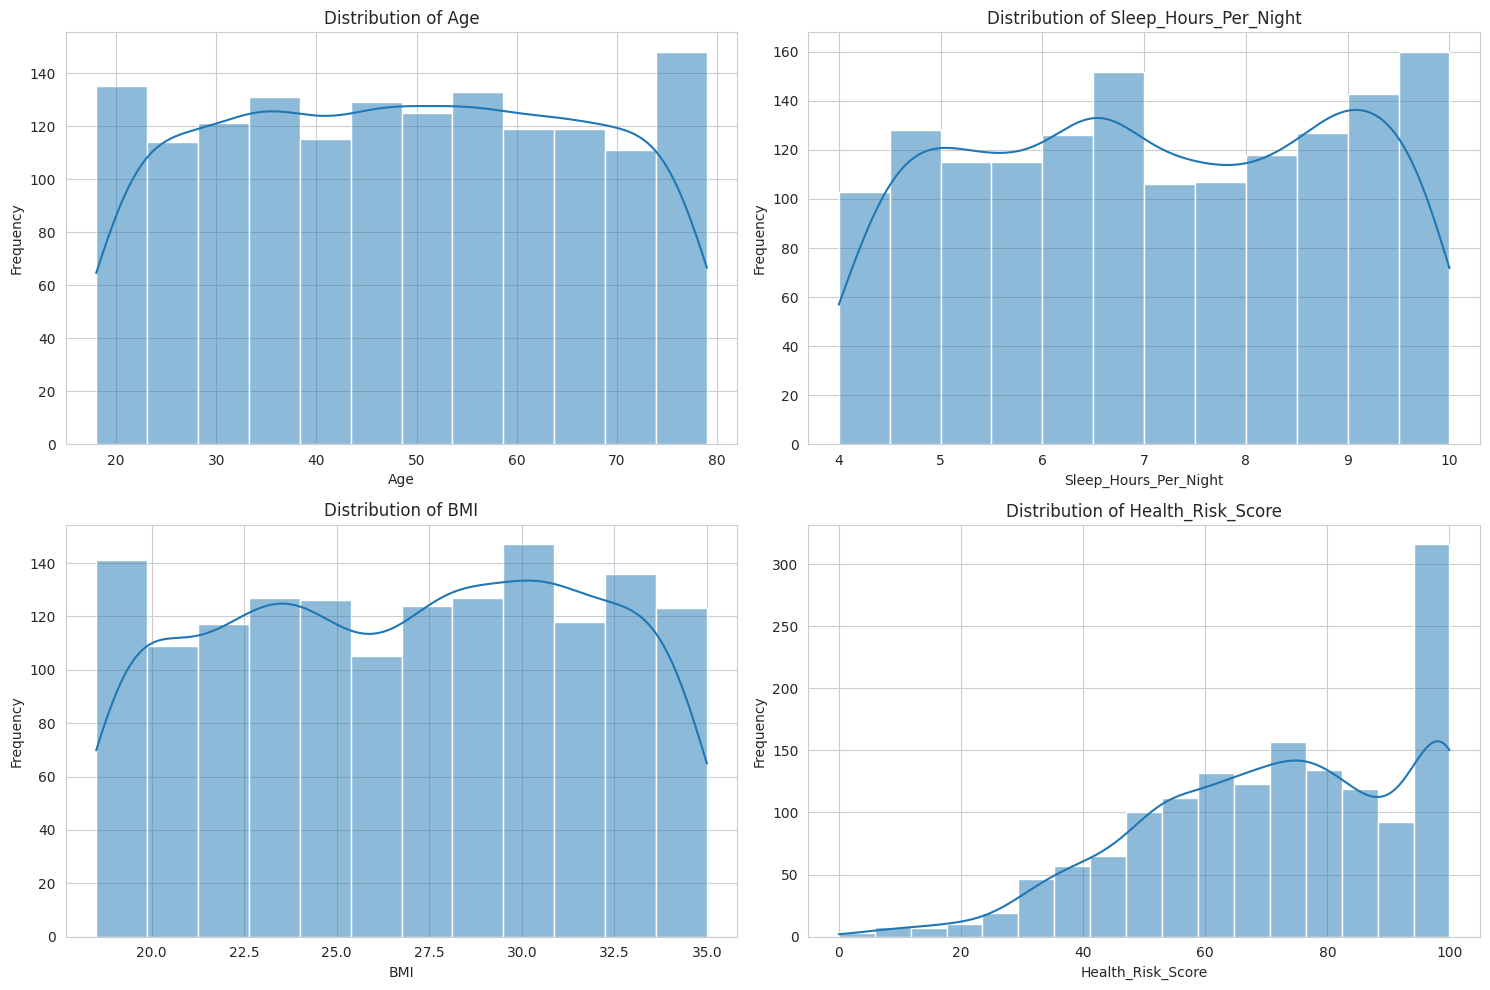

Histograms for numerical features displayed.


In [4]:
numerical_features = ['Age', 'Sleep_Hours_Per_Night', 'BMI', 'Health_Risk_Score']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_synthetic[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Histograms for numerical features displayed.")

## Distribution of Categorical and Ordinal Features

Count plots are used to visualize the distribution of categorical and ordinal
variables such as gender, diet quality, exercise frequency, stress levels,
smoking status, alcohol consumption, and risk classification.

These visualizations provide insights into class balance and behavioral trends
within the synthetic population.


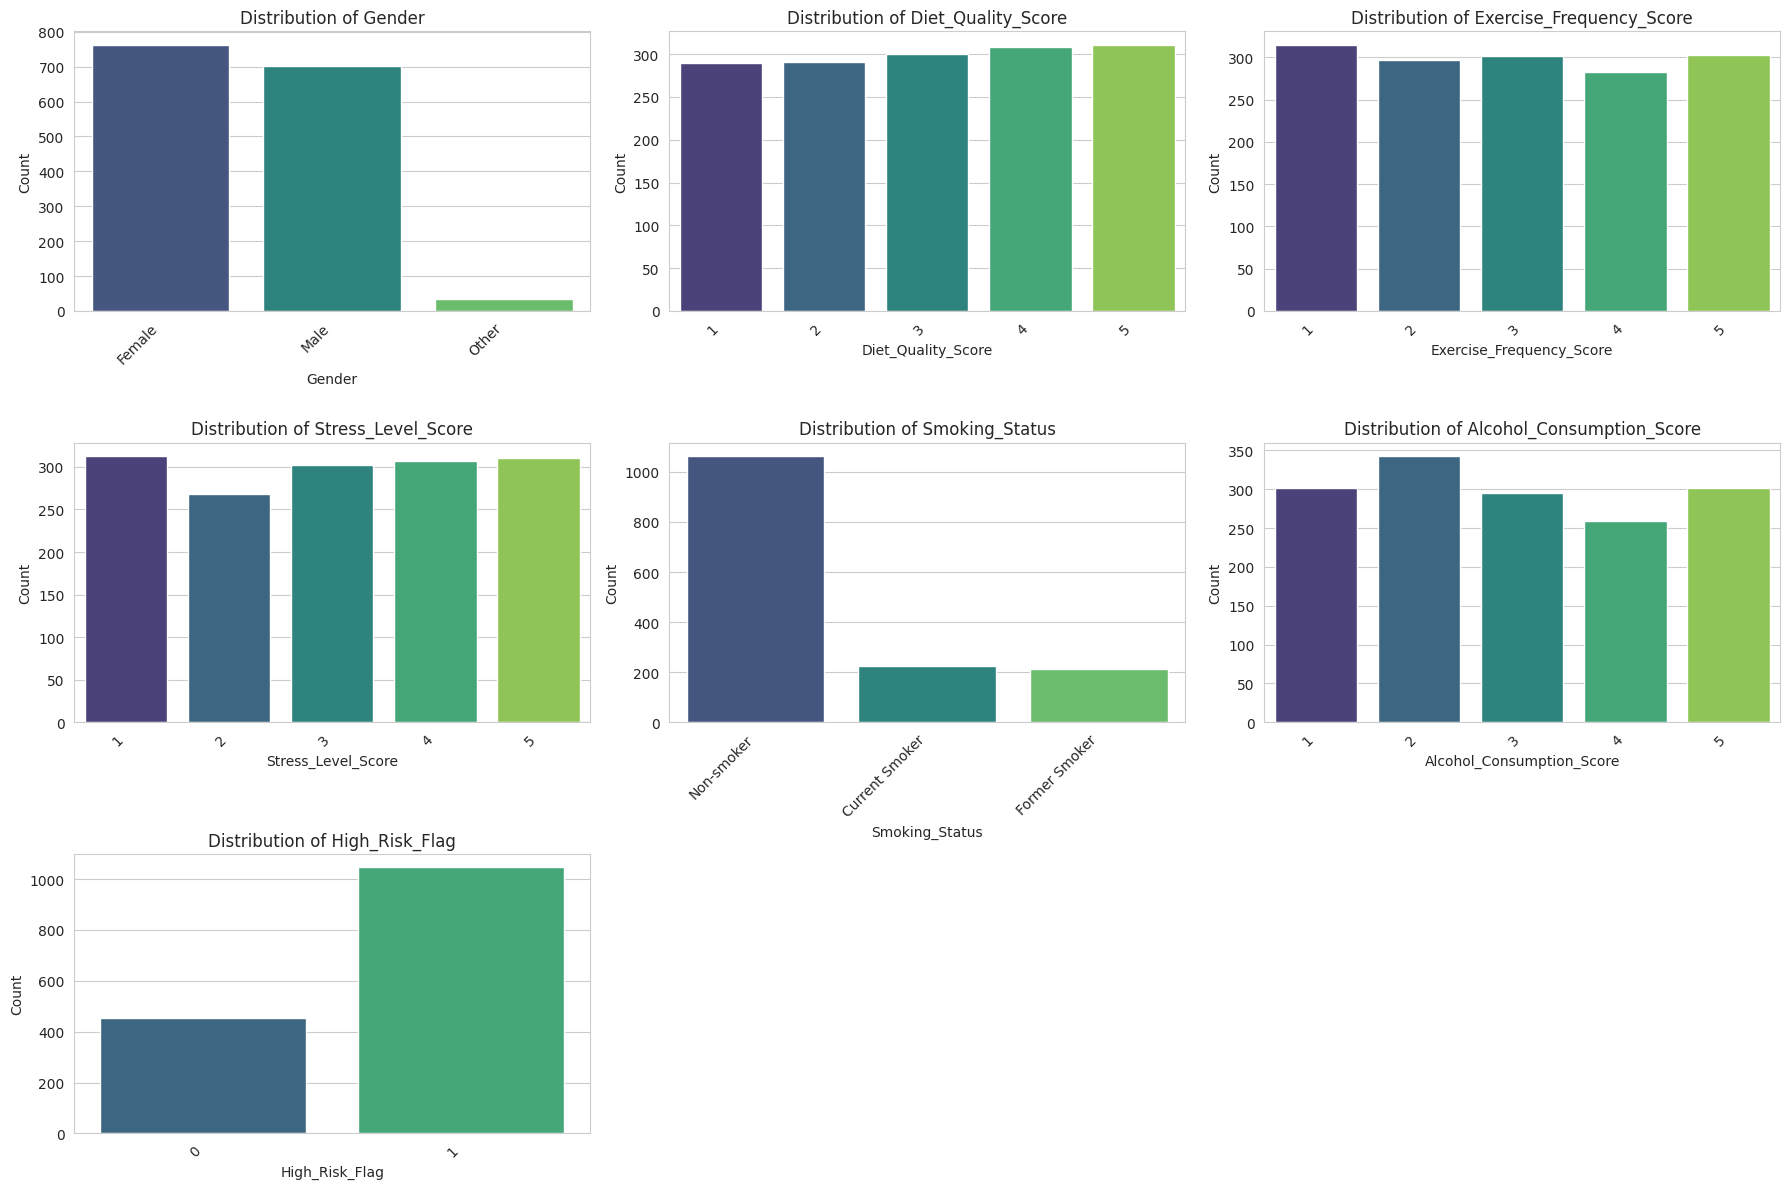

Count plots for categorical features displayed.


In [5]:
categorical_features = ['Gender', 'Diet_Quality_Score', 'Exercise_Frequency_Score', 'Stress_Level_Score', 'Smoking_Status', 'Alcohol_Consumption_Score', 'High_Risk_Flag']

plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=df_synthetic, x=col, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Count plots for categorical features displayed.")

## Correlation Analysis of Numerical Features

A correlation matrix is generated to examine relationships between numerical
features, including the health risk score. This analysis helps identify which
variables are strongly associated with overall risk.

Correlation insights are useful for understanding feature importance and
potential multicollinearity before model training.


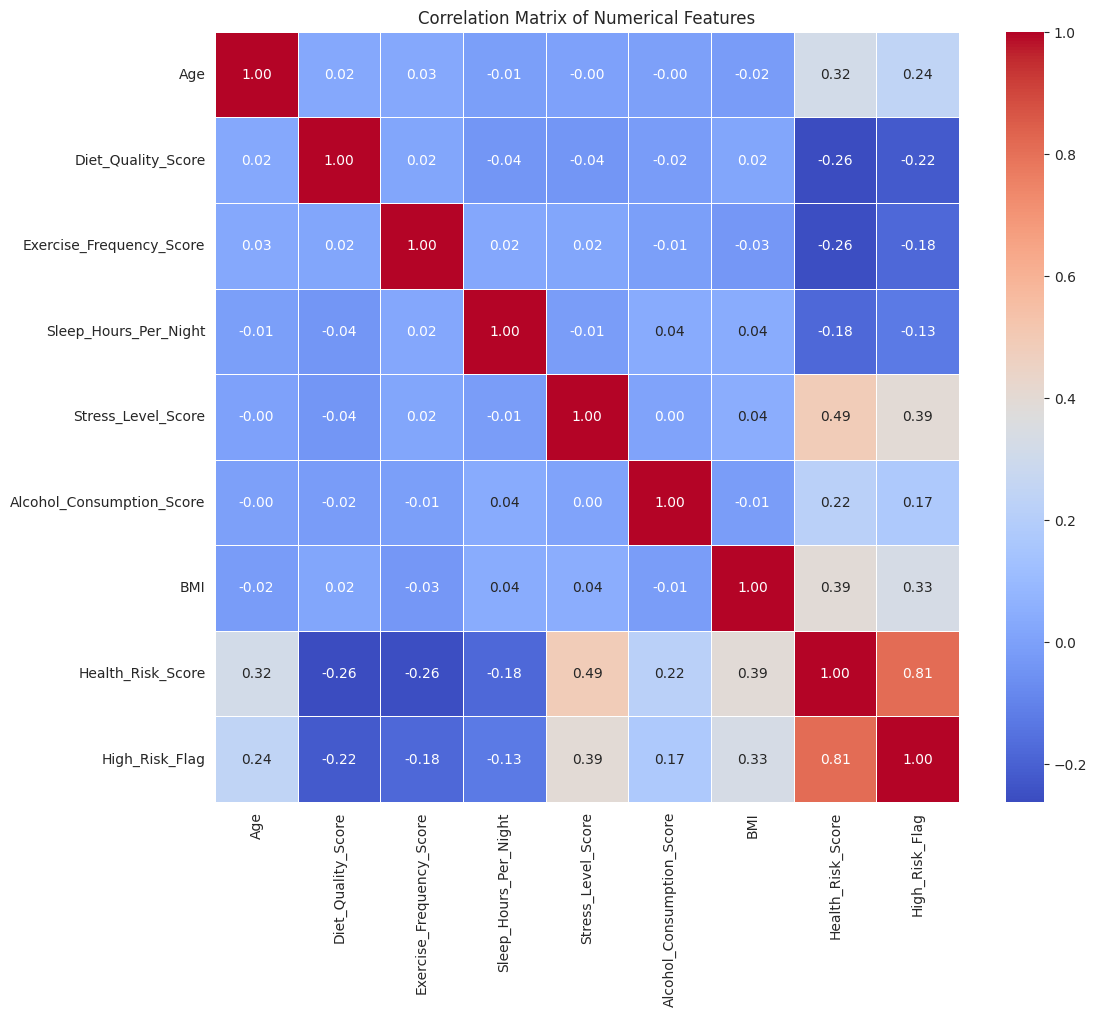

Correlation matrix and heatmap for numerical features displayed.


In [6]:
numerical_cols = df_synthetic.select_dtypes(include=np.number).columns
correlation_matrix = df_synthetic[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("Correlation matrix and heatmap for numerical features displayed.")

## Relationship Between Lifestyle Factors and Health Risk

Scatter plots and box plots are used to explore how different lifestyle factors
relate to the health risk score. Numerical features are visualized using scatter
plots, while categorical and ordinal features are analyzed using box plots.

These visualizations help validate whether the constructed risk score aligns
with intuitive health risk patterns.


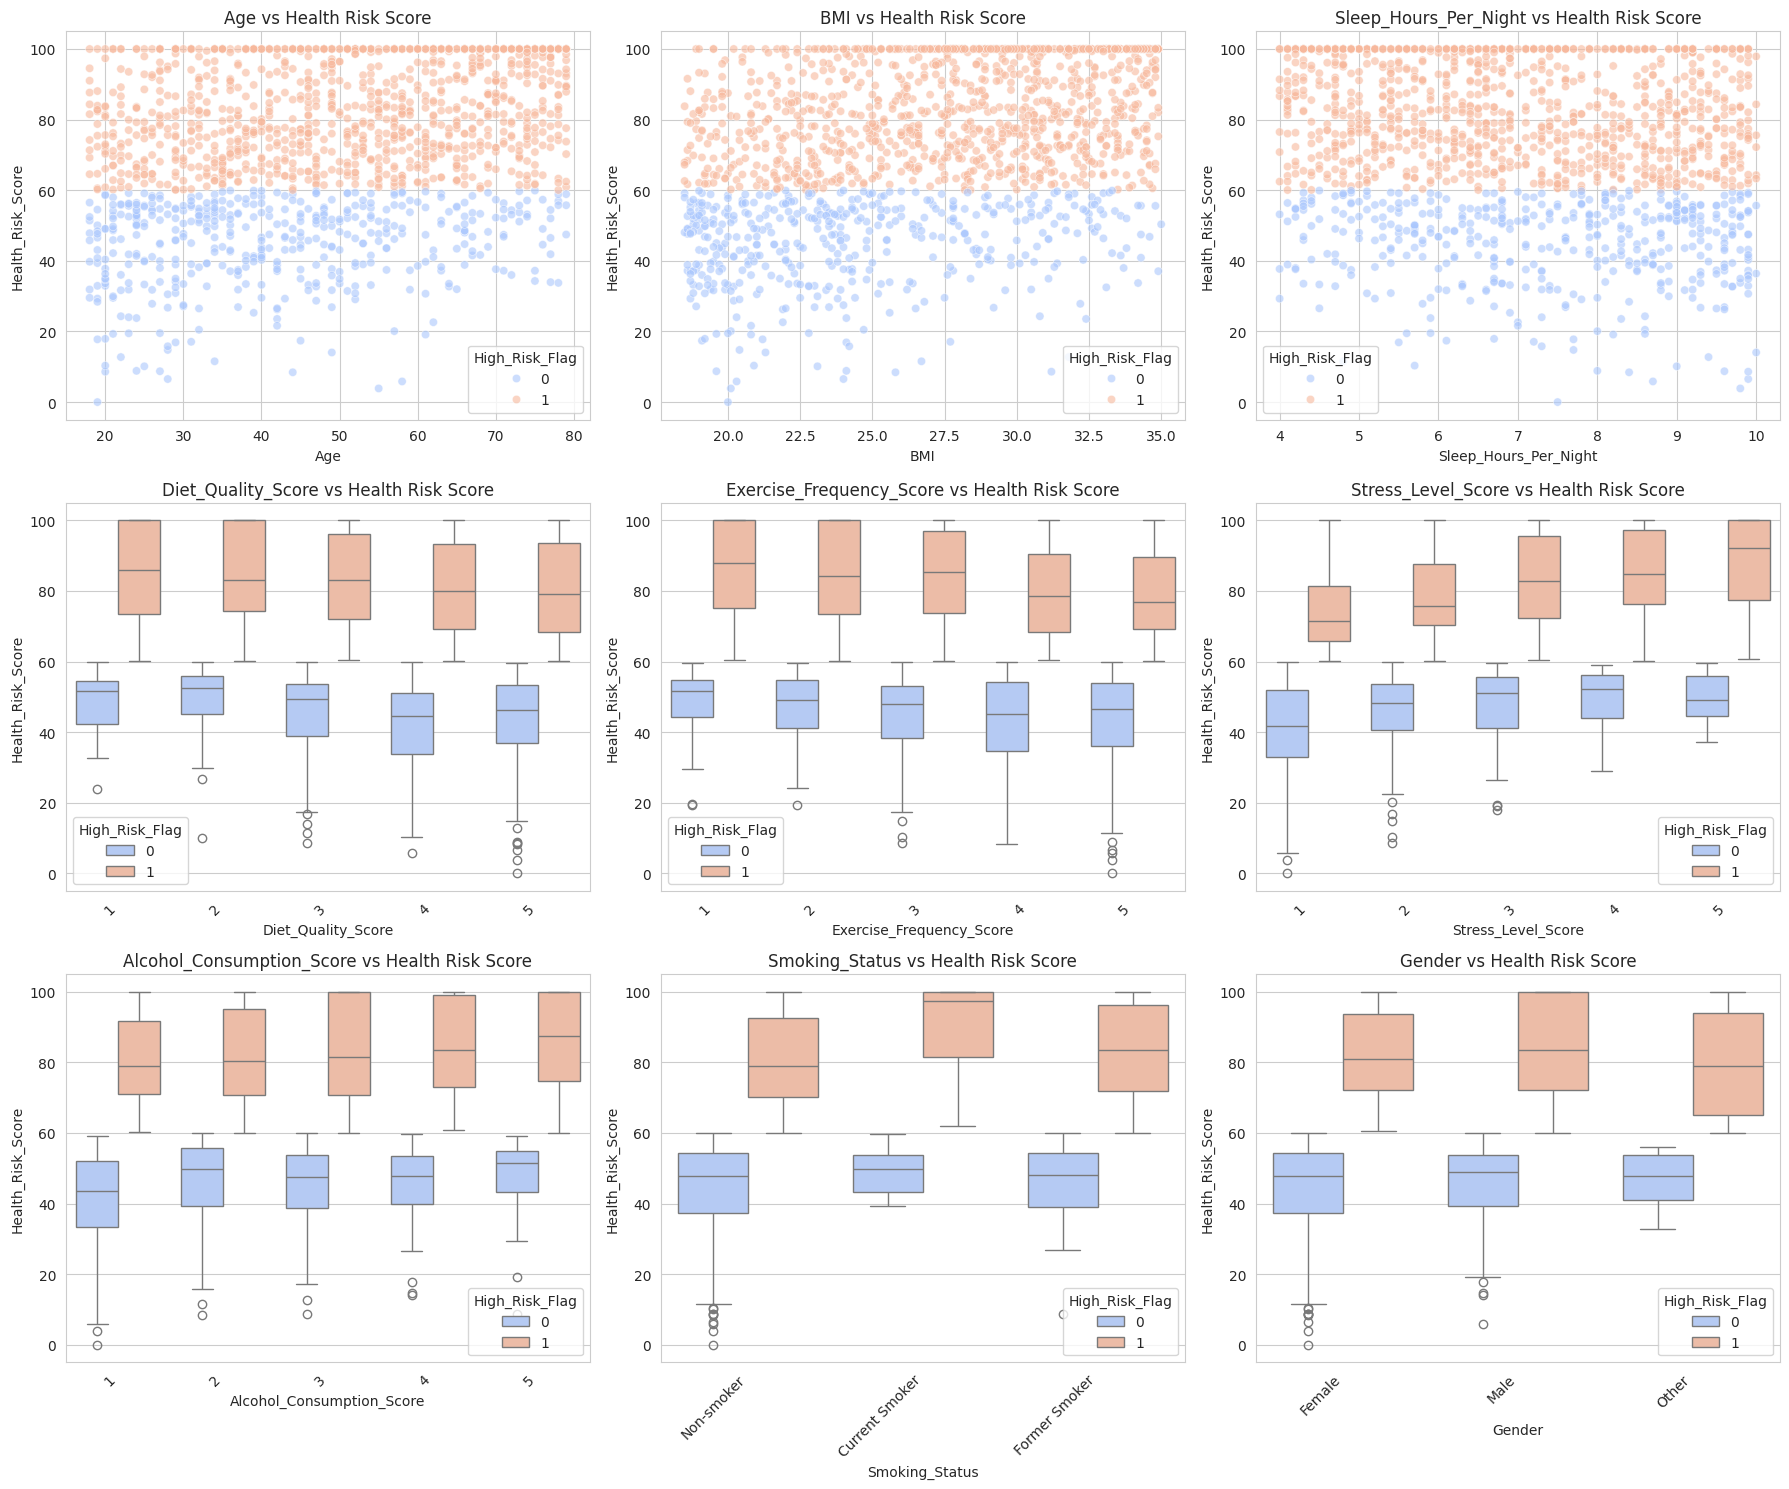

Scatter plots and box plots showing relationship between lifestyle factors and Health_Risk_Score displayed.


In [7]:
plt.figure(figsize=(18, 15))

# Numerical features vs Health_Risk_Score
scatter_features = ['Age', 'BMI', 'Sleep_Hours_Per_Night']
for i, col in enumerate(scatter_features):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=df_synthetic, x=col, y='Health_Risk_Score', hue='High_Risk_Flag', palette='coolwarm', alpha=0.6)
    plt.title(f'{col} vs Health Risk Score')
    plt.xlabel(col)
    plt.ylabel('Health_Risk_Score')

# Categorical/Ordinal features vs Health_Risk_Score (using box plots)
box_features = ['Diet_Quality_Score', 'Exercise_Frequency_Score', 'Stress_Level_Score', 'Alcohol_Consumption_Score', 'Smoking_Status', 'Gender']
for i, col in enumerate(box_features):
    plt.subplot(3, 3, len(scatter_features) + i + 1) # Continue plotting in the same figure
    sns.boxplot(data=df_synthetic, x=col, y='Health_Risk_Score', hue='High_Risk_Flag', palette='coolwarm')
    plt.title(f'{col} vs Health Risk Score')
    plt.xlabel(col)
    plt.ylabel('Health_Risk_Score')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Scatter plots and box plots showing relationship between lifestyle factors and Health_Risk_Score displayed.")

## Health Risk Score Distribution

The overall distribution of the health risk score is visualized to understand
how individuals are spread across different risk levels. A threshold line is
included to indicate the boundary used for high-risk classification.

This step provides a final check on the risk scoring logic before moving on to
feature engineering and model training.


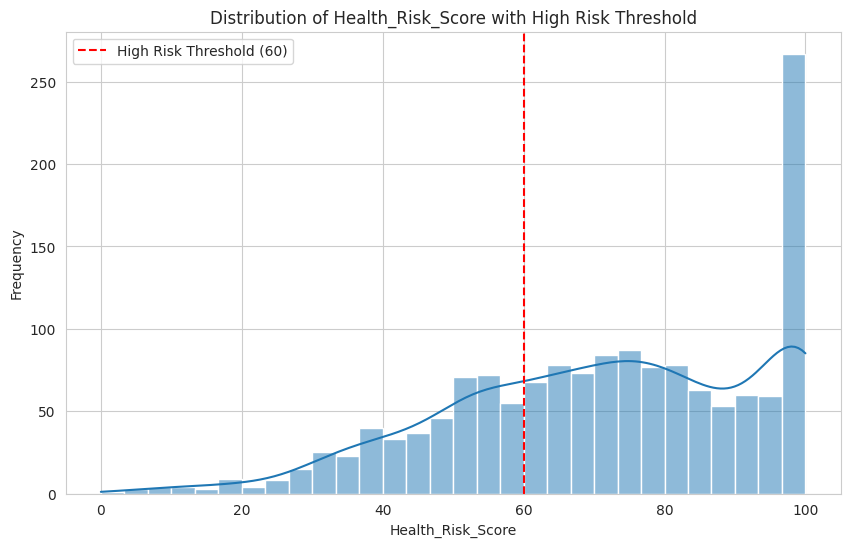

Histogram of Health_Risk_Score with high-risk threshold displayed.


In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_synthetic['Health_Risk_Score'], kde=True, bins=30)
plt.axvline(x=60, color='red', linestyle='--', label='High Risk Threshold (60)')
plt.title('Distribution of Health_Risk_Score with High Risk Threshold')
plt.xlabel('Health_Risk_Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print("Histogram of Health_Risk_Score with high-risk threshold displayed.")

## Rule-Based Health Risk Scoring

A rule-based health risk score is created to provide a transparent and
interpretable assessment of lifestyle-related risk factors. The score is
calculated using factors such as age, diet quality, physical activity, sleep,
stress level, smoking status, alcohol consumption, and BMI.

Each factor contributes to the overall risk based on predefined thresholds.
The final score is normalized to a 0–100 scale, making it easy to compare with
machine learning model predictions and improving overall explainability.


In [9]:
def calculate_rule_based_risk(row):
    score = 0

    # Age: Older age increases risk
    if row['Age'] >= 65:
        score += 20
    elif row['Age'] >= 45:
        score += 10

    # Diet Quality: Poor diet increases risk (Diet_Quality_Score 1-5, 1=poor, 5=excellent)
    score += (6 - row['Diet_Quality_Score']) * 5 # Max 25 points for poor diet

    # Exercise Frequency: Low exercise increases risk (Exercise_Frequency_Score 1-5, 1=never, 5=daily)
    score += (6 - row['Exercise_Frequency_Score']) * 4 # Max 20 points for no exercise

    # Sleep Hours: Less sleep increases risk (e.g., < 6 hours)
    if row['Sleep_Hours_Per_Night'] < 6:
        score += 15
    elif row['Sleep_Hours_Per_Night'] < 7:
        score += 5

    # Stress Level: High stress increases risk (Stress_Level_Score 1-5, 1=low, 5=high)
    score += row['Stress_Level_Score'] * 5 # Max 25 points for high stress

    # Smoking Status: Current/Former smokers increase risk
    if row['Smoking_Status'] == 'Current Smoker':
        score += 30
    elif row['Smoking_Status'] == 'Former Smoker':
        score += 15

    # Alcohol Consumption: Heavy consumption increases risk (Alcohol_Consumption_Score 1-5, 1=none, 5=heavy)
    score += (row['Alcohol_Consumption_Score'] - 1) * 4 # Max 16 points for heavy alcohol

    # BMI: High BMI increases risk
    if row['BMI'] >= 30:
        score += 20
    elif row['BMI'] >= 25:
        score += 10

    return score

df_synthetic['Rule_Based_Risk_Score'] = df_synthetic.apply(
    calculate_rule_based_risk, axis=1
)

# Normalize Rule-Based Risk Score to 0–100 range
min_score = df_synthetic['Rule_Based_Risk_Score'].min()
max_score = df_synthetic['Rule_Based_Risk_Score'].max()

if max_score != min_score:
    df_synthetic['Rule_Based_Risk_Score'] = (
        (df_synthetic['Rule_Based_Risk_Score'] - min_score)
        / (max_score - min_score)
    ) * 100
else:
    df_synthetic['Rule_Based_Risk_Score'] = 0

print(df_synthetic[['Rule_Based_Risk_Score']].head())

   Rule_Based_Risk_Score
0              46.268657
1              29.850746
2              41.791045
3              43.283582
4              35.074627


## Validation of Rule-Based Risk Score

To evaluate the consistency between the rule-based health risk score and the
computed health risk score used for modeling, a correlation analysis is
performed.

A strong positive correlation indicates that the rule-based logic aligns well
with the overall health risk trends captured in the dataset. This comparison
helps validate the effectiveness of the manually defined risk scoring rules.


In [10]:
correlation = df_synthetic['Rule_Based_Risk_Score'].corr(df_synthetic['Health_Risk_Score'])
print(f"Correlation between Rule_Based_Risk_Score and Health_Risk_Score: {correlation:.2f}")

Correlation between Rule_Based_Risk_Score and Health_Risk_Score: 0.84


## Comparison of Risk Score Distributions

The distributions of the machine-generated health risk score and the
rule-based risk score are visualized side by side. This comparison highlights
differences in score spread and concentration across the population.

Visual analysis helps assess whether both scoring approaches capture similar
risk patterns while still allowing for variation in how risk is quantified.


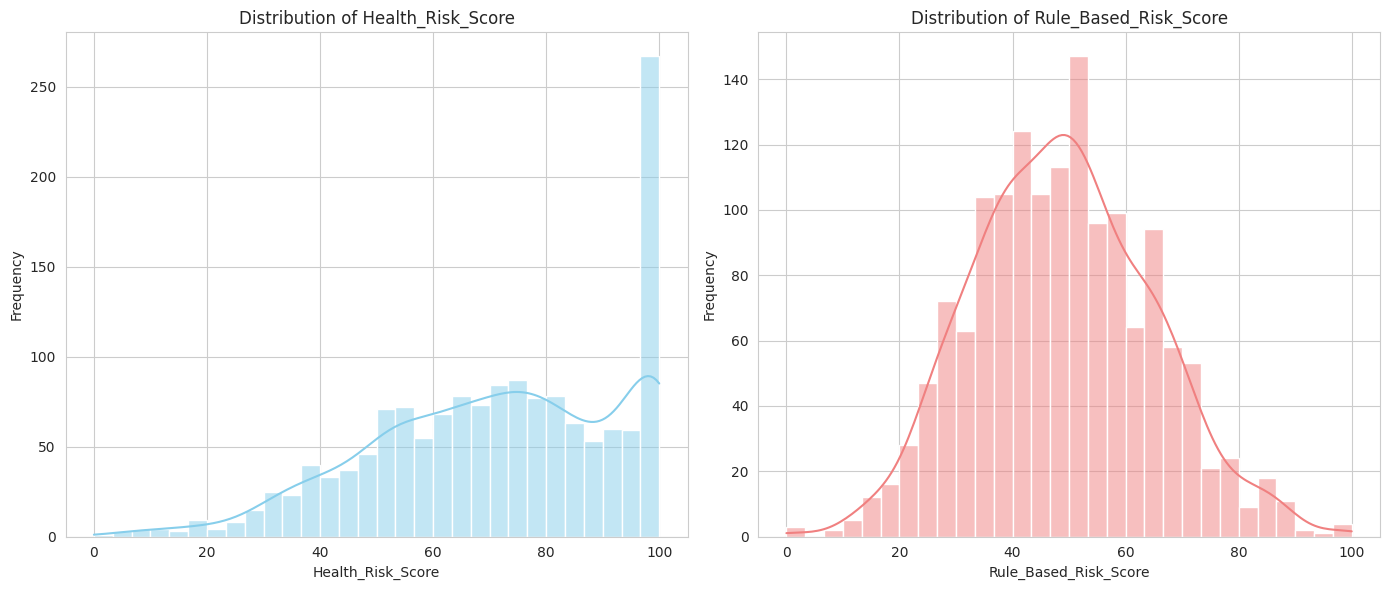

Histograms comparing Health_Risk_Score and Rule_Based_Risk_Score displayed.


In [11]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_synthetic['Health_Risk_Score'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Health_Risk_Score')
plt.xlabel('Health_Risk_Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_synthetic['Rule_Based_Risk_Score'], kde=True, bins=30, color='lightcoral')
plt.title('Distribution of Rule_Based_Risk_Score')
plt.xlabel('Rule_Based_Risk_Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Histograms comparing Health_Risk_Score and Rule_Based_Risk_Score displayed.")

## Data Preprocessing for ML

### Subtask:
Prepare the synthetic data for machine learning models, including handling categorical variables, scaling numerical features, and splitting the dataset into training, validation, and test sets.


## Feature Selection and Encoding

The dataset is divided into input features and a target variable for prediction.
The target variable represents whether an individual falls into a high-risk
health category.

Categorical variables such as gender and smoking status are converted into
numerical form using one-hot encoding, while numerical lifestyle features are
retained directly. This ensures that all inputs are suitable for machine
learning models.


In [12]:
X = df_synthetic.drop(
    ['Health_Risk_Score', 'High_Risk_Flag', 'Rule_Based_Risk_Score'], axis=1
)
y = df_synthetic['High_Risk_Flag']

categorical_features = ['Gender', 'Smoking_Status']
numerical_features = [
    'Age', 'Diet_Quality_Score', 'Exercise_Frequency_Score',
    'Sleep_Hours_Per_Night', 'Stress_Level_Score',
    'Alcohol_Consumption_Score', 'BMI'
]

X_categorical_encoded = pd.get_dummies(
    X[categorical_features], drop_first=True
)

X_processed = pd.concat(
    [X[numerical_features], X_categorical_encoded], axis=1
)

## Data Splitting and Feature Scaling

The processed dataset is split into training, validation, and test sets to
ensure reliable model evaluation. Stratified sampling is used to maintain
class balance across all subsets.

Numerical features are scaled using standardization to improve model
performance, while one-hot encoded categorical features are left unchanged.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training (70%) and temp (30% for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

# Split temp into validation (15%) and test (15%) - 0.5 of 0.3 is 0.15
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize StandardScaler
scaler = StandardScaler()

# Identify numerical columns in X_processed to apply scaling.
# These are the original numerical features plus any derived numerical features from categorical if they were not one-hot encoded.
# Given current setup, only original numerical_features need scaling.
# Note: One-hot encoded columns are already binary (0 or 1) and generally not scaled in this manner.

# Ensure we only scale the numerical part of the features
numerical_cols_for_scaling = ['Age', 'Diet_Quality_Score', 'Exercise_Frequency_Score', 'Sleep_Hours_Per_Night', 'Stress_Level_Score', 'Alcohol_Consumption_Score', 'BMI']

# Fit the scaler on the training data's numerical features
scaler.fit(X_train[numerical_cols_for_scaling])

# Transform numerical features for all sets
X_train[numerical_cols_for_scaling] = scaler.transform(X_train[numerical_cols_for_scaling])
X_val[numerical_cols_for_scaling] = scaler.transform(X_val[numerical_cols_for_scaling])
X_test[numerical_cols_for_scaling] = scaler.transform(X_test[numerical_cols_for_scaling])

print("Data split into training, validation, and test sets.")
print("Numerical features scaled using StandardScaler.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Data split into training, validation, and test sets.
Numerical features scaled using StandardScaler.
X_train shape: (1050, 11), y_train shape: (1050,)
X_val shape: (225, 11), y_val shape: (225,)
X_test shape: (225, 11), y_test shape: (225,)


## Machine Learning Model Development

### Subtask:
Train and evaluate multiple machine learning models (e.g., Logistic Regression, Random Forest, Gradient Boosting) for early health risk screening. Compare their performance.


## Model Selection

Multiple classification models are imported to compare different learning
approaches. Both linear and ensemble-based models are evaluated to understand
their performance on health risk prediction.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Necessary ML models and metrics imported.")

Necessary ML models and metrics imported.


## Logistic Regression Model

Logistic Regression is used as a baseline classification model due to its
simplicity and interpretability. The model is trained using the training
dataset and evaluated on the validation set using standard classification
metrics.


In [15]:
print("\n--- Logistic Regression ---")
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')
log_reg_model.fit(X_train, y_train)

y_pred_log_reg = log_reg_model.predict(X_val)
y_proba_log_reg = log_reg_model.predict_proba(X_val)[:, 1]

accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
precision_log_reg = precision_score(y_val, y_pred_log_reg)
recall_log_reg = recall_score(y_val, y_pred_log_reg)
f1_log_reg = f1_score(y_val, y_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_val, y_proba_log_reg)

print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1-Score: {f1_log_reg:.4f}")
print(f"ROC AUC Score: {roc_auc_log_reg:.4f}")


--- Logistic Regression ---
Accuracy: 0.9067
Precision: 0.9250
Recall: 0.9427
F1-Score: 0.9338
ROC AUC Score: 0.9719


## Model Interpretability Using Feature Coefficients

To understand the factors influencing predictions, Logistic Regression
coefficients are analyzed. The magnitude of each coefficient indicates the
relative importance of a feature in determining health risk.

This approach provides transparent and human-interpretable explanations
without relying on complex external explainability tools.


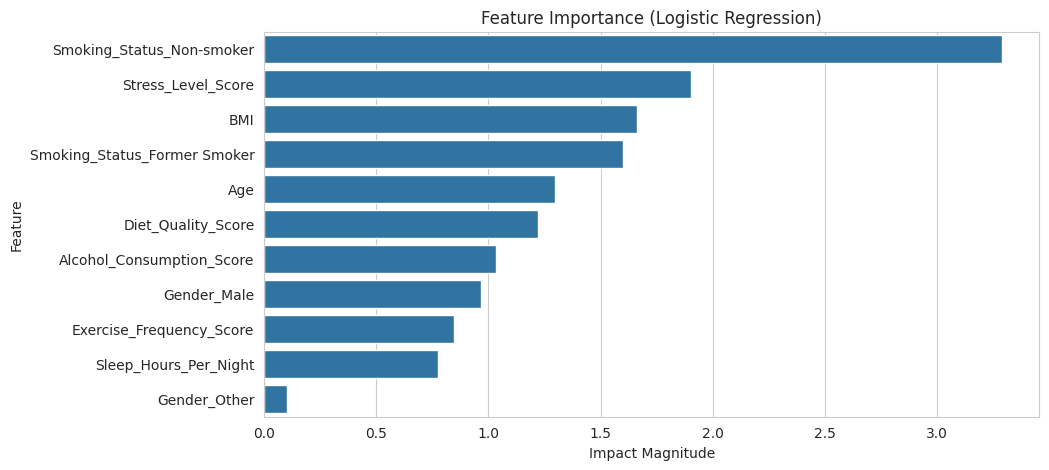

In [16]:
# Explainability using Logistic Regression coefficients
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg_model.coef_[0]
})

importance_df['Absolute_Impact'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute_Impact', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(
    x='Absolute_Impact',
    y='Feature',
    data=importance_df
)
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Impact Magnitude')
plt.ylabel('Feature')
plt.show()


## Random Forest Classifier

A Random Forest classifier is trained to capture non-linear relationships
between lifestyle factors and health risk. Its performance is compared against
the baseline Logistic Regression model.


In [17]:
print("\n--- Random Forest Classifier ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
y_proba_rf = rf_model.predict_proba(X_val)[:, 1]

accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
roc_auc_rf = roc_auc_score(y_val, y_proba_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"ROC AUC Score: {roc_auc_rf:.4f}")


--- Random Forest Classifier ---
Accuracy: 0.8756
Precision: 0.8817
Recall: 0.9490
F1-Score: 0.9141
ROC AUC Score: 0.9446


## Gradient Boosting Classifier

Gradient Boosting is used as an advanced ensemble technique to further evaluate
model performance. This model helps assess whether boosting methods improve
prediction accuracy for health risk screening.


In [18]:
print("\n--- Gradient Boosting Classifier ---")
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)

y_pred_gbc = gbc_model.predict(X_val)
y_proba_gbc = gbc_model.predict_proba(X_val)[:, 1]

accuracy_gbc = accuracy_score(y_val, y_pred_gbc)
precision_gbc = precision_score(y_val, y_pred_gbc)
recall_gbc = recall_score(y_val, y_pred_gbc)
f1_gbc = f1_score(y_val, y_pred_gbc)
roc_auc_gbc = roc_auc_score(y_val, y_proba_gbc)

print(f"Accuracy: {accuracy_gbc:.4f}")
print(f"Precision: {precision_gbc:.4f}")
print(f"Recall: {recall_gbc:.4f}")
print(f"F1-Score: {f1_gbc:.4f}")
print(f"ROC AUC Score: {roc_auc_gbc:.4f}")


--- Gradient Boosting Classifier ---
Accuracy: 0.8889
Precision: 0.9024
Recall: 0.9427
F1-Score: 0.9221
ROC AUC Score: 0.9570


# Model Explainability (XAI)

## Explainable AI using SHAP

To improve transparency, SHAP (SHapley Additive exPlanations) is used to explain
the predictions made by the Logistic Regression model. SHAP values quantify
the contribution of each feature to the final prediction.

This visualization highlights the most influential lifestyle factors affecting
health risk predictions, helping ensure interpretability and trust in the model.


In [19]:
import shap

print("SHAP library imported.")

SHAP library imported.


In [20]:
if ENABLE_SHAP:
    explainer = shap.Explainer(log_reg_model, X_train)
    shap_values = explainer(X_val)

    plt.figure(figsize=(10, 5))
    shap.plots.bar(shap_values, show=False)
    plt.title("Feature Importance using SHAP (Logistic Regression)")
    plt.show()


## Risk Recommendations Engine

Based on the identified lifestyle risk factors, a rule-based recommendation
system is used to generate personalized wellness suggestions. The
recommendations focus on general lifestyle improvements such as stress
management, sleep quality, physical activity, and habit modification.

This approach ensures that outputs are interpretable, ethical, and suitable
for preventive health awareness without providing medical advice.


In [21]:
def generate_recommendations(row):
    recommendations = []

    if row['Stress_Level_Score'] >= 4:
        recommendations.append("High stress detected. Consider relaxation techniques such as meditation or regular physical activity.")

    if row['Sleep_Hours_Per_Night'] < 6:
        recommendations.append("Low sleep duration observed. Aim for 7–9 hours of sleep to support better health.")

    if row['Exercise_Frequency_Score'] <= 2:
        recommendations.append("Low physical activity level. Increasing daily movement can help reduce health risks.")

    if row['Smoking_Status'] == 'Current Smoker':
        recommendations.append("Smoking significantly increases health risks. Seeking support to quit can have long-term benefits.")

    if row['Alcohol_Consumption_Score'] >= 4:
        recommendations.append("High alcohol intake detected. Reducing consumption may improve overall well-being.")

    if not recommendations:
        recommendations.append("No major lifestyle risk factors detected. Continue maintaining healthy habits.")

    return recommendations


# 🔹 DISPLAY OUTPUT FOR SAMPLE USERS (THIS CREATES IMPRESSIVE OUTPUTS)

sample_indices = df_synthetic.sample(3, random_state=42).index

for idx in sample_indices:
    print(f"\n🔹 Individual ID: {idx}")
    print("Lifestyle Profile:")
    display(df_synthetic.loc[idx, [
        'Age', 'Diet_Quality_Score', 'Exercise_Frequency_Score',
        'Sleep_Hours_Per_Night', 'Stress_Level_Score',
        'Smoking_Status', 'Alcohol_Consumption_Score', 'BMI'
    ]])

    print("Generated Recommendations:")
    recs = generate_recommendations(df_synthetic.loc[idx])
    for r in recs:
        print(f"- {r}")



🔹 Individual ID: 1116
Lifestyle Profile:


,1116
Age,54
Diet_Quality_Score,1
Exercise_Frequency_Score,1
Sleep_Hours_Per_Night,5.3
Stress_Level_Score,5
Smoking_Status,Non-smoker
Alcohol_Consumption_Score,2
BMI,19.8


Generated Recommendations:
- High stress detected. Consider relaxation techniques such as meditation or regular physical activity.
- Low sleep duration observed. Aim for 7–9 hours of sleep to support better health.
- Low physical activity level. Increasing daily movement can help reduce health risks.

🔹 Individual ID: 1368
Lifestyle Profile:


,1368
Age,66
Diet_Quality_Score,5
Exercise_Frequency_Score,3
Sleep_Hours_Per_Night,6.8
Stress_Level_Score,1
Smoking_Status,Former Smoker
Alcohol_Consumption_Score,4
BMI,22.4


Generated Recommendations:
- High alcohol intake detected. Reducing consumption may improve overall well-being.

🔹 Individual ID: 422
Lifestyle Profile:


,422
Age,65
Diet_Quality_Score,3
Exercise_Frequency_Score,5
Sleep_Hours_Per_Night,5.1
Stress_Level_Score,5
Smoking_Status,Non-smoker
Alcohol_Consumption_Score,1
BMI,30.3


Generated Recommendations:
- High stress detected. Consider relaxation techniques such as meditation or regular physical activity.
- Low sleep duration observed. Aim for 7–9 hours of sleep to support better health.


## Interactive Health Risk Assessment Tool

An interactive interface is provided to allow users to manually input lifestyle
factors such as age, sleep duration, stress level, physical activity, and habits.
Based on the inputs, the system predicts an overall health risk category and
provides personalized lifestyle recommendations.

This interface demonstrates how machine learning models can be integrated into
user-facing tools while maintaining transparency, stability, and ethical
boundaries.



In [22]:
import ipywidgets as widgets
from IPython.display import display, HTML

print("ipywidgets and IPython.display imported.")

ipywidgets and IPython.display imported.


### User Input Controls

The following sliders and dropdowns allow users to enter basic lifestyle information such as age, sleep duration, stress level, physical activity, and habits. These inputs are non-clinical and safe for educational screening.


In [23]:
age_widget = widgets.IntSlider(min=df_synthetic['Age'].min(), max=df_synthetic['Age'].max(), step=1, description='Age:')
gender_widget = widgets.Dropdown(options=df_synthetic['Gender'].unique().tolist(), description='Gender:')
diet_widget = widgets.IntSlider(min=df_synthetic['Diet_Quality_Score'].min(), max=df_synthetic['Diet_Quality_Score'].max(), step=1, description='Diet Quality (1-5):')
exercise_widget = widgets.IntSlider(min=df_synthetic['Exercise_Frequency_Score'].min(), max=df_synthetic['Exercise_Frequency_Score'].max(), step=1, description='Exercise Frequency (1-5):')
sleep_widget = widgets.FloatSlider(min=df_synthetic['Sleep_Hours_Per_Night'].min(), max=df_synthetic['Sleep_Hours_Per_Night'].max(), step=0.1, description='Sleep Hours:')
stress_widget = widgets.IntSlider(min=df_synthetic['Stress_Level_Score'].min(), max=df_synthetic['Stress_Level_Score'].max(), step=1, description='Stress Level (1-5):')
smoking_widget = widgets.Dropdown(options=df_synthetic['Smoking_Status'].unique().tolist(), description='Smoking Status:')
alcohol_widget = widgets.IntSlider(min=df_synthetic['Alcohol_Consumption_Score'].min(), max=df_synthetic['Alcohol_Consumption_Score'].max(), step=1, description='Alcohol Consumption (1-5):')
bmi_widget = widgets.FloatSlider(min=df_synthetic['BMI'].min(), max=df_synthetic['BMI'].max(), step=0.1, description='BMI:')

input_widgets = [
    age_widget,
    gender_widget,
    diet_widget,
    exercise_widget,
    sleep_widget,
    stress_widget,
    smoking_widget,
    alcohol_widget,
    bmi_widget
]

print("Interactive input widgets created.")

Interactive input widgets created.


### Risk Prediction & Recommendation Logic

This function processes user inputs, applies the same preprocessing steps used during model training, and predicts the health risk category. It also generates simple lifestyle suggestions to promote preventive awareness.


In [24]:
def predict_and_recommend(Age, Gender, Diet_Quality_Score, Exercise_Frequency_Score,
                          Sleep_Hours_Per_Night, Stress_Level_Score, Smoking_Status,
                          Alcohol_Consumption_Score, BMI):

    user_input = pd.DataFrame([{
        'Age': Age,
        'Gender': Gender,
        'Diet_Quality_Score': Diet_Quality_Score,
        'Exercise_Frequency_Score': Exercise_Frequency_Score,
        'Sleep_Hours_Per_Night': Sleep_Hours_Per_Night,
        'Stress_Level_Score': Stress_Level_Score,
        'Smoking_Status': Smoking_Status,
        'Alcohol_Consumption_Score': Alcohol_Consumption_Score,
        'BMI': BMI
    }])

    user_cat = pd.get_dummies(user_input[categorical_features], drop_first=True)

    for col in X_processed.columns:
        if col not in user_cat.columns and col not in numerical_features:
            user_cat[col] = 0

    user_cat = user_cat[X_processed.drop(numerical_features, axis=1).columns]
    user_final = pd.concat([user_input[numerical_features], user_cat], axis=1)

    user_final[numerical_cols_for_scaling] = scaler.transform(
        user_final[numerical_cols_for_scaling].astype(float)
    )

    user_final = user_final[X_train.columns]

    pred = log_reg_model.predict(user_final)[0]
    prob = log_reg_model.predict_proba(user_final)[0][1] * 100

    # Simple human-style recommendations
    recommendations = []

    if Stress_Level_Score >= 4:
        recommendations.append("Explore stress-reduction techniques like meditation or light exercise.")
    if Exercise_Frequency_Score <= 2:
        recommendations.append("Increase physical activity to at least 30 minutes per day.")
    if Sleep_Hours_Per_Night < 6:
        recommendations.append("Improve sleep duration and consistency.")
    if Smoking_Status == "Current Smoker":
        recommendations.append("Consider quitting smoking for long-term health benefits.")

    if not recommendations:
        recommendations.append("No major lifestyle risks detected. Keep maintaining healthy habits.")

    risk_label = "HIGH RISK" if pred == 1 else "LOW / MODERATE RISK"

    html = f"""
    <h3>Health Risk Assessment</h3>
    <b>Risk Category:</b> {risk_label}<br>
    <b>Estimated Risk Probability:</b> {prob:.2f}%<br><br>

    <b>Personalized Lifestyle Suggestions</b>
    <ul>
        {''.join(f"<li>{r}</li>" for r in recommendations)}
    </ul>
    """

    display(HTML(html))


### Live Risk Assessment Output

Adjust the sliders to instantly view the predicted risk category and personalized lifestyle suggestions. This interactive design helps users understand how daily habits influence overall health risk.


In [25]:
interactive_output = widgets.interactive_output(
    predict_and_recommend,
    {
        'Age': age_widget,
        'Gender': gender_widget,
        'Diet_Quality_Score': diet_widget,
        'Exercise_Frequency_Score': exercise_widget,
        'Sleep_Hours_Per_Night': sleep_widget,
        'Stress_Level_Score': stress_widget,
        'Smoking_Status': smoking_widget,
        'Alcohol_Consumption_Score': alcohol_widget,
        'BMI': bmi_widget
    }
)

display(
    widgets.VBox(input_widgets),
    interactive_output
)


Output()

# Project Summary
This notebook presented a Crisis Response Assistant using NLP and Retrieval-Augmented Generation (RAG) designed strictly for non-clinical, non-diagnostic, and educational use.

## Key Highlights
- A structured knowledge base containing supportive, pre-curated educational content
- Semantic retrieval using sentence embeddings and cosine similarity
- Safe and empathetic response generation grounded only in retrieved knowledge
- Rule-based safety detection for high-risk inputs with immediate fallback guidance
- Explainable responses showing the source category and title of retrieved information
- End-to-end pipeline demonstration with diverse user scenarios
- A simple interactive text interface for real-time usage
- Throughout the system, responsible AI principles such as transparency, safety, limitation awareness, and ethical boundaries were strictly followed.
